# Warsaw Weather Data Analysis

## Description:
This project focuses on performing Exploratory Data Analysis (EDA) on a 30-year weather dataset from the Warsaw Airport weather station. The main variables of interest are temperature, snow depth, and precipitation. The goal is to gain insights and draw meaningful conclusions from the data, as well as visualize the findings.

## Project scope:
 - Obtaining data via API
 - Formatting  and filtering of data
 - EDA for temperature, snow depth, and precipitation
 - Data visualization for the above-mentioned characteristics
 - Insights obtained from EDA

## Setup project:

Import required libraries:

In [1]:
# Import libraries
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter, date2num
import numpy as np
import pandas as pd
import seaborn as sns
import requests

Access databases through the API (<b>it is important to have it set up at this point, see README for instructions</b>):

In [2]:
# Data Retrieval
# Accessing data from the API
api_url = "http://127.0.0.1:5000/weather"

# Make sure API server is running (see README file), otherwise next cell will end with connection error

Get the whole data from API call:

In [3]:
# Save API response into dataframe
response = requests.get(api_url)
data = response.json()
df = pd.DataFrame(data)

## Dataset validation:

In [4]:
# View the first 5 rows of the dataframe
df.head()

,DATE,ELEVATION,LATITUDE,LONGITUDE,NAME,PRCP,SNWD,STATION,TAVG
0,"Fri, 01 Jan 1993 00:00:00 GMT",110.3,52.166,20.967,"OKECIE, PL",0.0,10.0,PLM00012375,-8.3
1,"Sat, 02 Jan 1993 00:00:00 GMT",110.3,52.166,20.967,"OKECIE, PL",NaN,10.0,PLM00012375,-14.9
2,"Sun, 03 Jan 1993 00:00:00 GMT",110.3,52.166,20.967,"OKECIE, PL",0.0,10.0,PLM00012375,-13.6
3,"Mon, 04 Jan 1993 00:00:00 GMT",110.3,52.166,20.967,"OKECIE, PL",0.0,10.0,PLM00012375,-10.5
4,"Tue, 05 Jan 1993 00:00:00 GMT",110.3,52.166,20.967,"OKECIE, PL",0.0,10.0,PLM00012375,-12.0


In [5]:
# View the last 5 rows of the dataframe
df.tail()

,DATE,ELEVATION,LATITUDE,LONGITUDE,NAME,PRCP,SNWD,STATION,TAVG
10949,"Tue, 27 Dec 2022 00:00:00 GMT",110.3,52.166,20.967,"OKECIE, PL",8.4,NaN,PLM00012375,4.7
10950,"Wed, 28 Dec 2022 00:00:00 GMT",110.3,52.166,20.967,"OKECIE, PL",0.0,NaN,PLM00012375,3.3
10951,"Thu, 29 Dec 2022 00:00:00 GMT",110.3,52.166,20.967,"OKECIE, PL",0.5,NaN,PLM00012375,6.8
10952,"Fri, 30 Dec 2022 00:00:00 GMT",110.3,52.166,20.967,"OKECIE, PL",0.0,NaN,PLM00012375,6.1
10953,"Sat, 31 Dec 2022 00:00:00 GMT",110.3,52.166,20.967,"OKECIE, PL",NaN,NaN,PLM00012375,9.4


In [6]:
# Check the shape of the DataFrame
df.shape

(10954, 9)

10954 entries divided by 365 days gives us 30 years, which confirms that the database covers daily data from that range.

In [7]:
# Check the data types of the columns
df.dtypes

DATE          object
ELEVATION    float64
LATITUDE     float64
LONGITUDE    float64
NAME          object
PRCP         float64
SNWD         float64
STATION       object
TAVG         float64
dtype: object

In [8]:
# Average missing values per year:
(df.isna().sum()/30).round().astype(int)

DATE           0
ELEVATION      0
LATITUDE       0
LONGITUDE      0
NAME           0
PRCP          60
SNWD         318
STATION        0
TAVG           0
dtype: int64

### The following gives us information :

- Since it is a database based on single station geolocation, columns and station IDs will always be the same and hence will have no missing values.
- Each entry has an assigned date, so there are no missing values here either. Later on, dates will be assigned as an index to the dataframe.
- There is always entry of an average temperature.
- <b>Missing values for snow depth and precipitation make sense</b> because these are not always present. They need to be kept in mind, however, during calculations of average values later on.
- Daily max and min temperatures entries have some missing data, but for this analysis only the average temperature is used.

### Formatting:

Using the knowledge obtained, we can separate static station data in case we need it later on and drop those columns from the original dataframe to get more contained data.

In [9]:
# Clean the dataframe
# Save station data into dictionary, as it is the same for each record, and there is no need to repeat that
station_data = {
    'STATION': [df.iloc[0]['STATION']],
    'NAME': [df.iloc[0]['NAME']],
    'LATITUDE': [df.iloc[0]['LATITUDE']],
    'LONGITUDE': [df.iloc[0]['LONGITUDE']],
    'ELEVATION': [df.iloc[0]['ELEVATION']]
}

# Create filtered df without static values
filtered_df = df.drop(["STATION","NAME","LATITUDE","LONGITUDE","ELEVATION"], axis=1)

# Fixed date to datetime format, in order to use it as an index
filtered_df['DATE'] = pd.to_datetime(df['DATE'])
filtered_df.set_index('DATE', inplace=True)

print(station_data)
filtered_df.head()

{'STATION': ['PLM00012375'], 'NAME': ['OKECIE, PL'], 'LATITUDE': [52.166], 'LONGITUDE': [20.967], 'ELEVATION': [110.3]}


,PRCP,SNWD,TAVG
DATE,,,
1993-01-01,0.0,10.0,-8.3
1993-01-02,NaN,10.0,-14.9
1993-01-03,0.0,10.0,-13.6
1993-01-04,0.0,10.0,-10.5
1993-01-05,0.0,10.0,-12.0


### Filter dataset via API:

We can make use of the filter by month query to get separate sets of data, one for each month. Additionally, we want one dataframe containing data from last year.

In [10]:
# Access data via API and fill seperate dataframe for each month
months = {}

for month in range(1, 13):
    response = requests.get(f'{api_url}?month={month}')
    data = response.json()
    df_API = pd.DataFrame(data)
    df_API = df_API.drop(['ELEVATION', 'LATITUDE', 'LONGITUDE', 'NAME'], axis=1)
    months[f'df_API_{month}'] = df_API

df_API['DATE'] = pd.to_datetime(df_API['DATE'])

In [11]:
# Call API for last year data
response = requests.get(f'{api_url}?date_start=2022-01-01&date_end=2022-12-31')
data = response.json()
df_last_year = pd.DataFrame(data)

# Save as df_last_year and perform formatting
df_last_year = df_last_year.drop(['ELEVATION', 'LATITUDE', 'LONGITUDE', 'NAME'], axis=1)
df_last_year['DATE'] = pd.to_datetime(df_last_year['DATE'])
df_last_year.set_index('DATE', inplace=True)

## Visualisation:

### Temperature analysis:

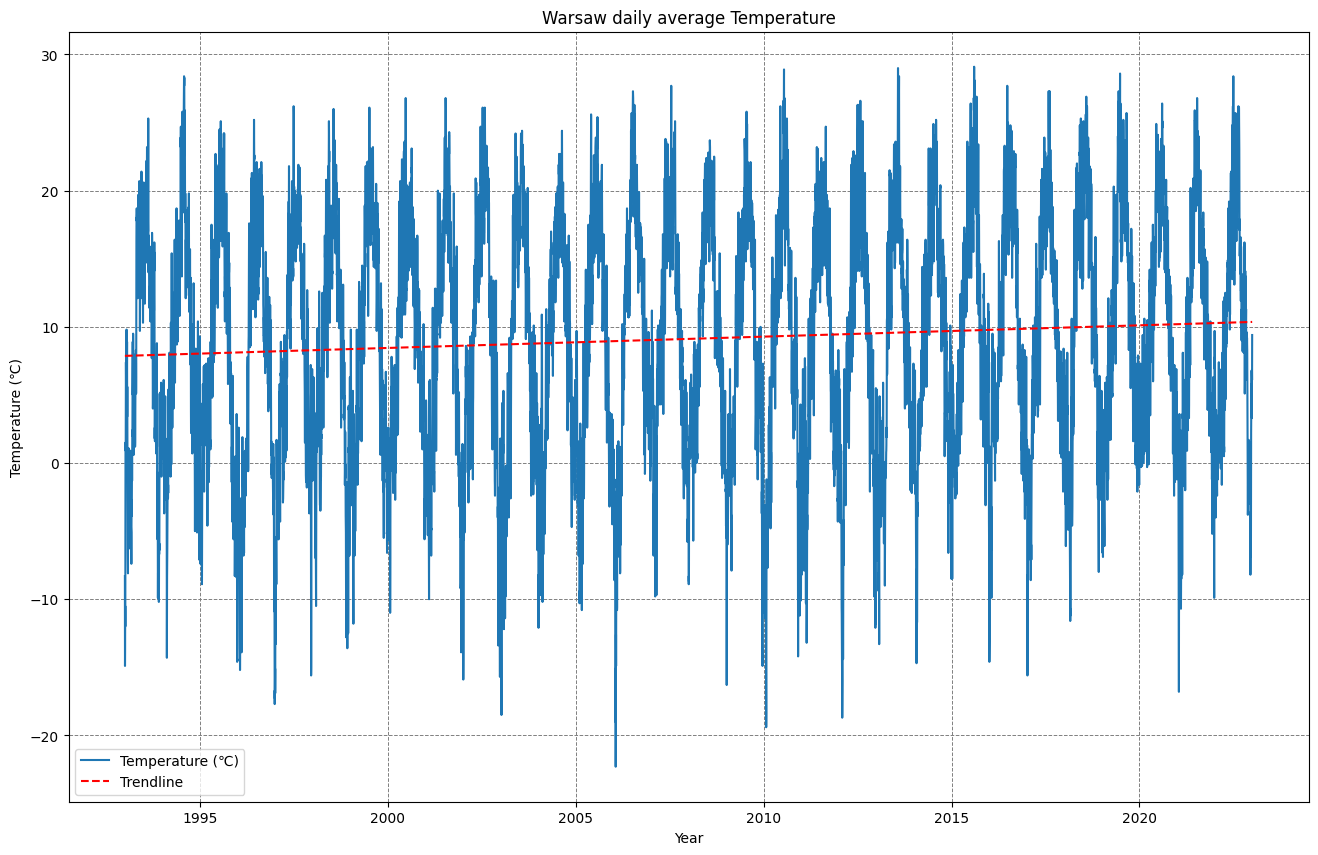

In [12]:
# Create yearly average temperature plot
fig, axs = plt.subplots(figsize=(16, 10))

# Plot
axs.plot(filtered_df.index, filtered_df["TAVG"])
axs.xaxis.set_major_locator(YearLocator(base=5))
axs.xaxis.set_major_formatter(DateFormatter('%Y'))
axs.set_xlabel("Year")
axs.set_ylabel("Temperature (\u2103)")
axs.set_title("Warsaw daily average Temperature")
axs.grid(True, color='grey', linewidth=0.7, linestyle='--')

# Calculate the linear trendline equation
x = date2num(filtered_df.index)
z = np.polyfit(x, filtered_df["TAVG"], 1)
p = np.poly1d(z)

axs.plot(x, p(x), color="red", linestyle="--")
axs.legend(["Temperature (\u2103)","Trendline"])

# Display the figure
plt.show()

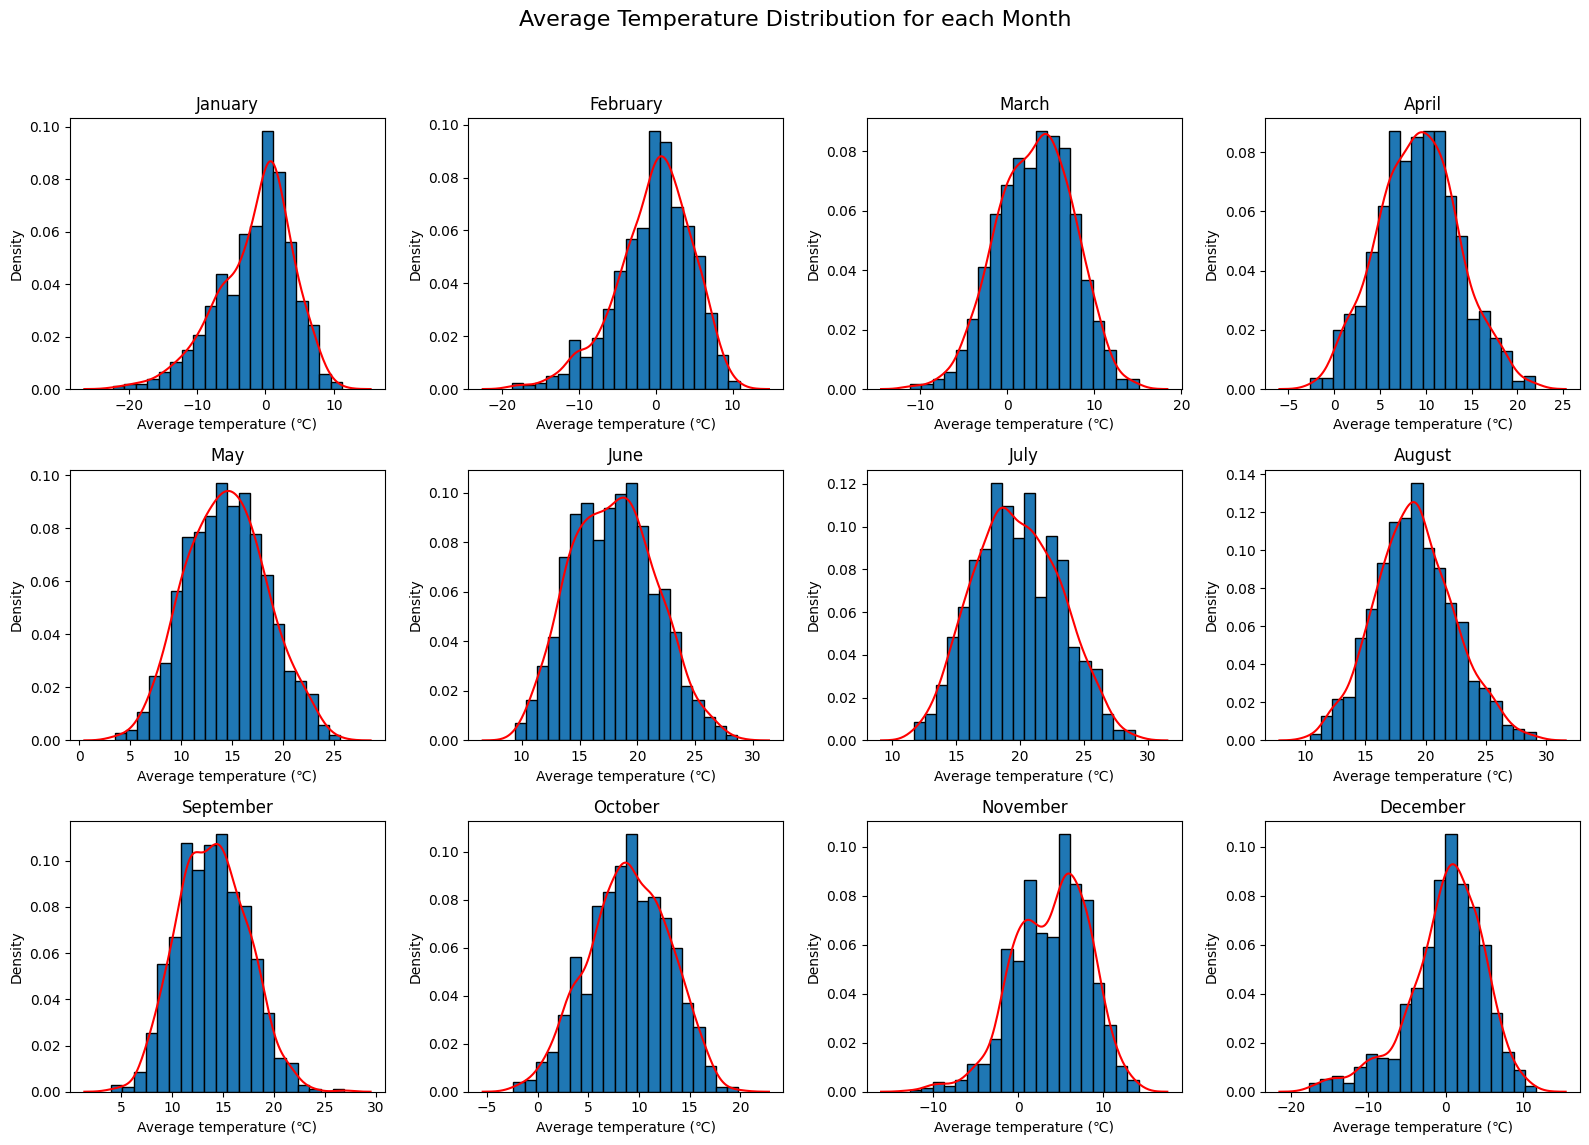

In [13]:
# Create seperate temperature distribution histogram for each month
# Initialize lists
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_mean = []
monthly_std = []

# Create a 3x4 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle("Average Temperature Distribution for each Month", fontsize=16)

# Loop through each month
for month_idx, month_name in enumerate(month_names):
    # Get the dataframe for the current month
    df_key = f'df_API_{month_idx + 1}'
    if df_key in months:
        current_month_df = months[df_key]
        current_month_temperatures = current_month_df["TAVG"]

        # Calculate average and standard deviation
        mean = np.mean(current_month_temperatures)
        monthly_mean.append(mean)
        std_dev = np.std(current_month_temperatures)
        monthly_std.append(std_dev)

        # Get the current subplot
        ax = axes[month_idx // 4, month_idx % 4]

        # Plot histogram
        ax.hist(current_month_temperatures, bins=20, edgecolor='black', density=True)

        # Plot KDE
        sns.kdeplot(current_month_temperatures, color='red', linestyle='-', label='Smoothed Line', ax=ax)

        # Set title and labels
        ax.set_title(month_name)
        ax.set_xlabel("Average temperature (\u2103)")
        ax.set_ylabel("Density")

# Adjust spacing and layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()

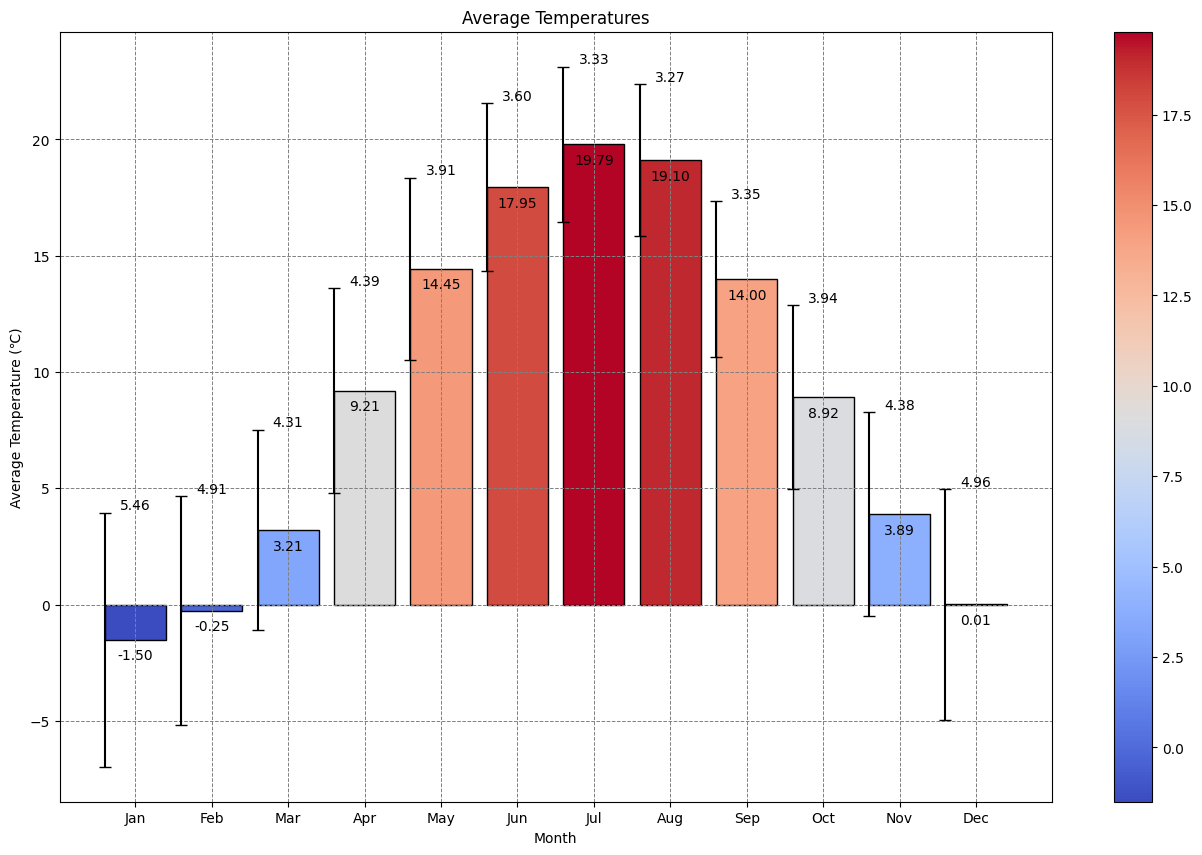

In [14]:
# Create average temperature per month bar plot
fig, axs = plt.subplots(figsize=(16, 10))

# Create a color map
cmap = plt.get_cmap('coolwarm')
# Normalize values to 0-1
norm = plt.Normalize(min(monthly_mean), max(monthly_mean))
# Apply the color map
colors = cmap(norm(monthly_mean))
# Create a color bar legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=axs)

# Create a bar plot
axs.bar(np.arange(12), monthly_mean, edgecolor='black', linewidth=1,color=colors)
# Move the error bars slightly to the left
errorbar_x = np.arange(12) - 0.4  # Adjust the value as needed

axs.errorbar(errorbar_x, monthly_mean, yerr=monthly_std, fmt='none', ecolor='black', capsize=4)

# Add value labels to each bar
for i, v in enumerate(monthly_mean):
     axs.text(i, v - 1, "{:.2f}".format(v), ha='center', va='bottom')

# Add numbers to the error bars
for i, (mean, std) in enumerate(zip(monthly_mean, monthly_std)):
    axs.annotate("{:.2f}".format(std), (i, mean + std), ha='center', va='bottom')

axs.set_xlabel("Month")
axs.set_ylabel("Average Temperature (\u2103)")
axs.set_title("Average Temperatures")
axs.set_xticks(np.arange(12))
axs.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
axs.grid(True, color='grey', linewidth=0.7, linestyle='--')

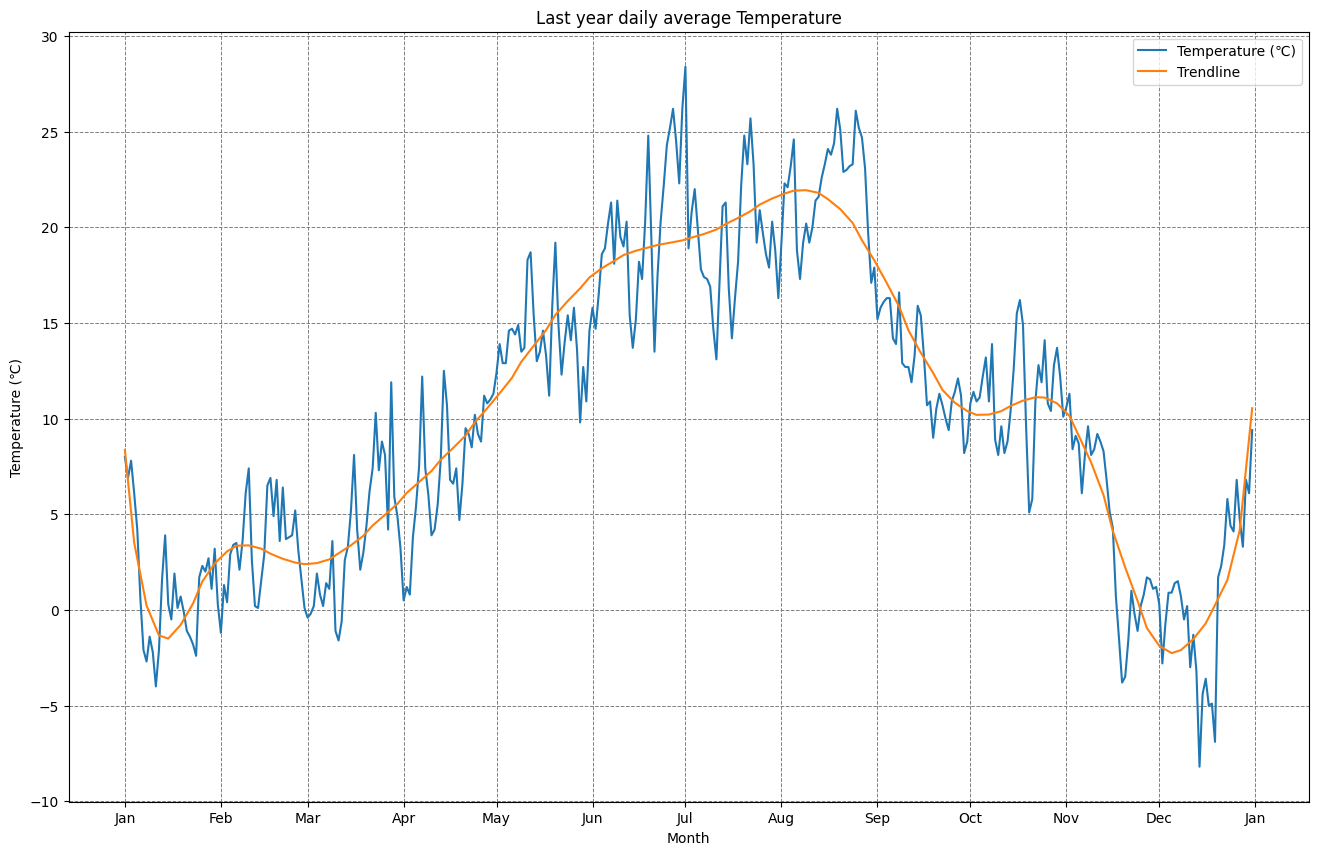

In [15]:
# Create the last year temperature plot
fig, axs = plt.subplots(figsize=(16, 10))

# Plot the first subplot
axs.plot(df_last_year.index, df_last_year["TAVG"])
axs.xaxis.set_major_locator(MonthLocator())
axs.xaxis.set_major_formatter(DateFormatter('%b'))
axs.set_xlabel("Month")
axs.set_ylabel("Temperature (\u2103)")
axs.set_title("Last year daily average Temperature")
axs.grid(True, color='grey', linewidth=0.7, linestyle='--')

# Calculate the polynomial coefficients
x = np.arange(len(df_last_year.index))
y = df_last_year["TAVG"]
degree = 15  # Set the degree of the polynomial
coeffs = np.polyfit(x, y, degree)

# Generate the trendline values
trendline_x = np.linspace(x.min(), x.max(), 100)
trendline_y = np.polyval(coeffs, trendline_x)

# Plot the trendline
axs.plot(df_last_year.index[trendline_x.astype(int)], trendline_y)
axs.legend(["Temperature (\u2103)","Trendline"])

# Display the figure
plt.show()

Lets look for data where average temperature was lower than -19C

In [16]:
# Get the data where the average temperature was lower than -19C
filtered_df.query("TAVG < -19")

,PRCP,SNWD,TAVG
DATE,,,
2006-01-22,2.3,259.0,-20.8
2006-01-23,0.0,259.0,-22.3
2006-01-24,NaN,259.0,-20.4
2010-01-25,0.0,290.0,-19.4


Now we can see more specific data surrounding that anomaly, it happened only in 2006 and was almost 2 degrees colder than in second coldest year.

In [17]:
# Get the data where the average temperature was higher than 28C
filtered_df.query("TAVG > 28")

,PRCP,SNWD,TAVG
DATE,,,
1994-07-30,0.0,NaN,28.4
1994-08-01,0.0,NaN,28.3
2010-07-17,0.0,NaN,28.9
2013-07-29,0.5,NaN,29.0
2013-08-08,0.0,NaN,28.4
2015-08-07,0.0,NaN,29.1
2015-08-08,0.0,NaN,29.1
2015-08-12,0.0,NaN,28.1
2019-06-26,0.0,NaN,28.6


On the other hand we can see that temperatures near max average temperature happens more often and temperature differance is not that much.

### Temperature analysis takeaways:

- The all-time trend line indicates that on the macro level, the average temperature is slowly increasing with time.
- Despite the fact that in winter seasons temperatures reached as low as -20 C, it was rather an exception, than a rule. In general, temperatures tend to stay near 0C. Such occurrences, however, increased the variance for the winter months.
- The summer season's average value has the least variance. In terms of temperatures, we can expect correct weather predictions more often.
- The spring and autumn months consistently have a wider range of temperatures. This is most visible as the density of March and April maxes around 0.08, which is the lowest for all months and makes their distribution more uniform.
- Winter season is less consistent in terms of lowest average temperatures in different years, while during the summer, the highest average temperature was similar for many years.

### Snowdepth analysis:

In [18]:
# Order snow depth and precipitation data for each month:
# Create an array to store the mean values for each month
mean_SNWD = []
mean_PRCP = []
# Loop through each month
for month_idx, month_name in enumerate(month_names):
    # Get the dataframe for the current month
    df_key = f'df_API_{month_idx + 1}'
    if df_key in months:
        current_month_df = months[df_key]
        # Fill SNWD list with formated data
        current_month_snwd = current_month_df["SNWD"].fillna(0)
        mean_SNWD.append(current_month_snwd.mean())
        
        # Fill PRCP list with formated data
        current_month_PRCP = current_month_df["PRCP"].fillna(0)
        mean_PRCP.append(current_month_PRCP.mean())
        
# Rearrange the list so that the months with snow are in the middle of a plot
mean_SNWD = mean_SNWD[6:12] + mean_SNWD[0:6]

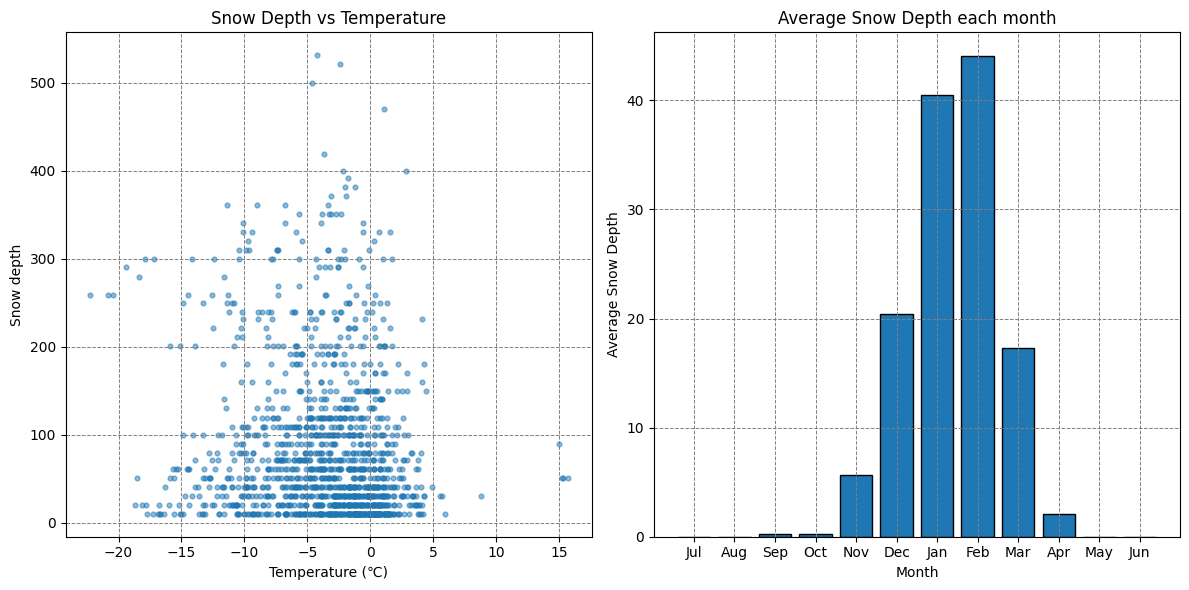

In [19]:
# Create 2 subplots (Snow Depth vs Temperature and Snow depth monthly)
# Create the subplot grid
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot SNWD vs Temperature subplot (left)
axs[0].scatter(filtered_df["TAVG"], filtered_df["SNWD"], alpha=0.5, s=12)
axs[0].set_xlabel("Temperature (\u2103)")
axs[0].set_ylabel("Snow depth")
axs[0].set_title("Snow Depth vs Temperature")
axs[0].grid(True, color='grey', linewidth=0.7, linestyle='--')

# Plot average SNWD monthly bar subplot (right)
axs[1].bar(np.arange(12), mean_SNWD, edgecolor='black', linewidth=1)
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Average Snow Depth")
axs[1].set_title("Average Snow Depth each month")
axs[1].set_xticks(np.arange(12))
axs[1].set_xticklabels(["Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun"])
axs[1].grid(True, color='grey', linewidth=0.7, linestyle='--')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

On the plot to the left, only entries where snow depth was present are displayed, but in the plot to the right, '0' values were also taken into account during the average calculation. It is important in both cases. In the case of a scatter plot, we don't want to see it polluted with '0' readings, which are the majority in this dataset. In the case of the bar plot, we want to know the average, taking the days without snow into account.

Now we can further inquire about specifics of certian events: for example the date at which snow depth was noted at aproximatly 15C, which is way above melting temperature:

In [20]:
# Get the data for snow at 15C
filtered_df.query("TAVG > 14 & SNWD > 0")

,PRCP,SNWD,TAVG
DATE,,,
1999-09-27,5.1,51.0,15.7
1999-09-28,0.0,51.0,15.3
1999-09-29,NaN,89.0,15.0
1999-09-30,4.6,51.0,15.2


or the date of the most depth noted:

In [21]:
# Get the data for most snow depth noted
filtered_df.query("SNWD > 490")

,PRCP,SNWD,TAVG
DATE,,,
2010-02-15,9.4,500.0,-4.6
2010-02-16,1.8,531.0,-4.2
2010-02-17,0.0,521.0,-2.4


### Snow depth analysis takeaways:

- Low amount of snow depth entries at -20C is tied to the fact that in 30 years range temperature dipped that low for only one season.
- On the other hand temperature range -10C to +10C is present much more often, but in positive ranges naturally snow melts, hence very rarely it is present on that plot above 5C.
- Most data points place snow depth in a range less than 2m.
- Average snow depth reflects winter season months in a most significant way, but to a lesser degree, snowfall happens in April and November as well.
- During January and February, the average was approximately twice as much as other winter seasons.

### Precipitation analysis:

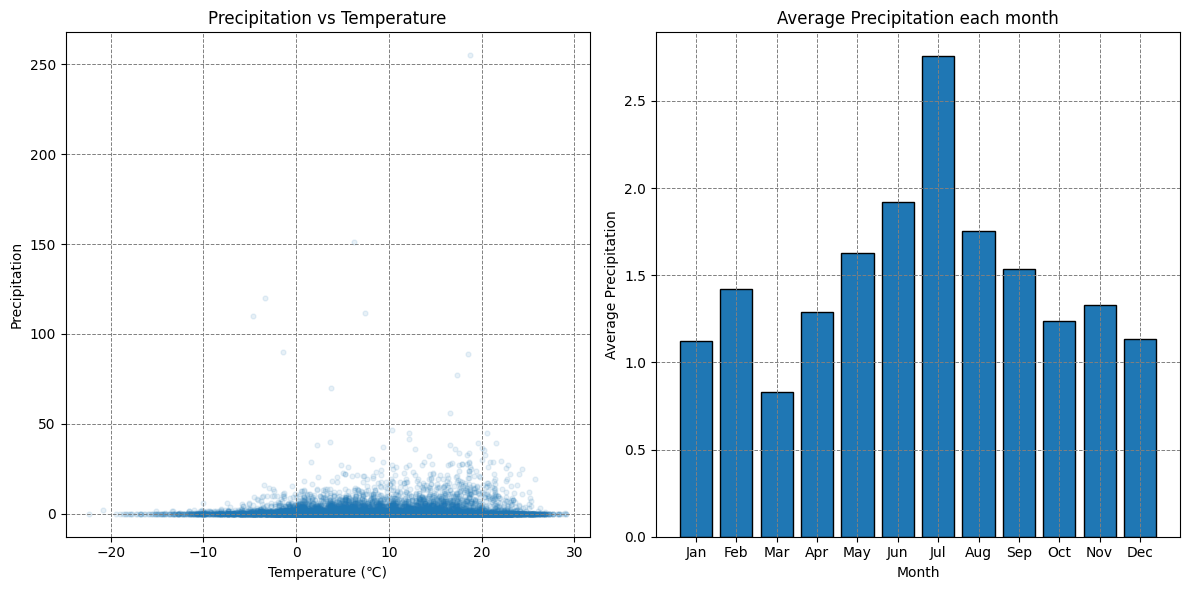

In [22]:
# Create 2 subplots (Precipitation vs Temperature and Precipitation monthly)
# Create the subplot grid
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot PRCP vs Temperature subplot (left)
axs[0].scatter(filtered_df["TAVG"], filtered_df["PRCP"], alpha=0.1, s=12)
axs[0].set_xlabel("Temperature (\u2103)")
axs[0].set_ylabel("Precipitation")
axs[0].set_title("Precipitation vs Temperature")
axs[0].grid(True, color='grey', linewidth=0.7, linestyle='--')

# Plot average PRCPD monthly bar subplot (right)
axs[1].bar(np.arange(12), mean_PRCP, edgecolor='black', linewidth=1)
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Average Precipitation")
axs[1].set_title("Average Precipitation each month")
axs[1].set_xticks(np.arange(12))
axs[1].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
axs[1].grid(True, color='grey', linewidth=0.7, linestyle='--')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Similarly to snow depth analysis, for a bar plot, missing values were replaced with 0. In this situation, however, it doesn't make that much of a difference since, on average, only 60 data points per year had no precipitation data (as opposed to snow depth with 318 missing data points). For the scatter plot, missing data was omitted.

List the days where precipitation was more than 50mm:

In [23]:
# Get data where precipitation is more than 50mm
filtered_df.query("PRCP > 50")

,PRCP,SNWD,TAVG
DATE,,,
1993-07-21,255.0,NaN,18.8
1997-07-26,55.9,NaN,16.6
2000-11-02,111.5,NaN,7.4
2000-11-05,151.1,NaN,6.2
2002-08-06,88.9,NaN,18.5
2011-07-31,77.0,NaN,17.4
2021-02-14,119.9,NaN,-3.4
2021-02-15,110.0,NaN,-4.7
2021-02-17,89.9,NaN,-1.4


As we can observe, considering data spans 30 years, such precipitation is not common at all

### Precipitation analysis takeaways:

- In general, in the span of 30 years, there was only a small amount of very heavy/extreme rain (more than 50mm). It much more often occupies the near-zero range, which  shows that Poland has moderate precipitation.
- As seen in the bar plot, the difference between the most wet and the most dry months is not that much. Values for each month are found entirely between 0.5 and 2.7, which is a small rain/drizzle range.

## Conclusion:

The analysis of a 30-year weather dataset from the Warsaw Airport weather station revealed significant insights into the weather patterns in Warsaw. The temperature analysis showcased clear seasonality, represented by a sinusoidal shape, while a trend line confirmed the influence of global warming. On a positive note, the precipitation analysis indicated that the majority of rainfall was relatively mild, which is typical for polish weather,  with only rare exceptions. Similar occurrences were observed in terms of one-time temperature dips below 20°C and the appearance of snow at around 15°C. Considering the span of the dataset and the frequency of such events, let's consider them anomalies. These findings contribute to a more comprehensive understanding of the climate in Warsaw and the effects of climate change.